## Hamiltonian Monte-Carlo for the Imprecise Learner and Horseshoe Prior

Author: Clara Hoffmann \
HMC (see f.e. 'MCMC using Hamiltonian dynamics' by Neal, 2011) to obtain the posterior
of the coefficients of the last hidden layer and the copula parameters

Overview:
1. Initialize Variables
2. Run HMC chain

Note that the CIL versions for HMC are especially time-consuming. Derivatives based on Klein, Nott \& Smith 'Marginally Calibrated Deep Distributional Regression' (2020).

In [1]:
# load packages
import numpy as np
from random import random
from tqdm import tqdm
import ray
import matplotlib.pyplot as plt
from helpers_horseshoe import generate_dS2_ddS2_S2_S, log_density, Leapfrog, Delta_theta
ray.init()

2021-01-20 15:37:48,307	INFO services.py:1090 -- View the Ray dashboard at http://127.0.0.1:8270


{'node_ip_address': '192.168.140.16',
 'raylet_ip_address': '192.168.140.16',
 'redis_address': '192.168.140.16:27911',
 'object_store_address': '/tmp/ray/session_2021-01-20_15-37-47_421304_1769720/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-01-20_15-37-47_421304_1769720/sockets/raylet',
 'webui_url': '127.0.0.1:8270',
 'session_dir': '/tmp/ray/session_2021-01-20_15-37-47_421304_1769720',
 'metrics_export_port': 57827,
 'node_id': '638bc2f839d3c0c8ab84608e84523e74daf767c2'}

## 1. Initialize Variables

In [ ]:
# import data from DNN training
extracted_coefficients_directory = '../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/'
B_zeta_path = str(extracted_coefficients_directory + 'Bzeta/B_zeta.npy')
beta_path = str(extracted_coefficients_directory + 'beta/beta.csv')
z_path = str(extracted_coefficients_directory + 'Bzeta/tr_labels.npy')
beta = np.genfromtxt(beta_path, delimiter=',')
B_zeta = np.load(B_zeta_path)
B_zeta = B_zeta.reshape(B_zeta.shape[0], beta.shape[0])
z = np.load(z_path)
tBB = B_zeta.T.dot(B_zeta)

In [ ]:
beta = np.repeat(0,10)
# number of samples we want to produce
M = 30000 + 1
L = 77

# number of parameters of theta
q = 2*B_zeta.shape[1] + 1
p = B_zeta.shape[1]

n = B_zeta.shape[0]

# start values for beta, lambda, tau
# beta is taken from trained network and other two
# are initialized randomly
theta_m_1 = np.zeros(q)

# stepsize
epsilon = 0.00005

# momentum
r_m = np.append(np.zeros(p), np.append(np.repeat(-6,p), 0))

tau_start = theta_m_1[q-1]
Lambda = np.repeat(1,p)
BoB = B_zeta**2

## 2. Run HMC chain

In [ ]:
seed = 6835963
# create lists to save results
r0 = np.repeat(None, 30000)
theta_tilde = np.repeat(None, 30000)
r_tilde = np.repeat(None, 30000)
log_dens = np.repeat(None, 30000)
r_tilde = np.repeat(None, M)
log_dens =  np.repeat(None, M)
alpha = np.repeat(None, M)
theta_m_1 = np.repeat(None, M)
r_m = np.repeat(None, M)
theta_m_1[0] = np.append(np.zeros(p), np.append(np.repeat(0,p), 0))

acc = []
theta_tilde[0] = np.zeros(21)
r_tilde[0] = np.zeros(21)
theta_m_1[1] =  np.append(np.zeros(p), np.append(np.repeat(0,p), 0))
all_thetas = []
theta_m_1[0] = np.append(np.zeros(p), np.append(np.repeat(0,p), 0))
r_m[0] = np.random.multivariate_normal(np.zeros(q), np.identity(q), 1)
r_m[1] = np.random.multivariate_normal(np.zeros(q), np.identity(q), 1)

# loop over number of samples that we want to produce
for m in tqdm(range(0, M)):
    
    # Update S
    # draw momentum from normal distribution
    r0[m] = np.random.multivariate_normal(np.zeros(q), np.identity(q), 1)
    
    # set new parameters
    theta_tilde[m] = np.array(theta_m_1[m]).reshape(q,)
    r_tilde[m] = r0[m]
    betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
    
    # compute gradient with theta
    Delta_theta_t = Delta_theta(theta_tilde[m], B_zeta, n, z, 
                                p, tBB, betaBt, BoB)

    # update momentum
    r_tilde[m] = r_tilde[m] + (epsilon*0.5)*Delta_theta_t
    
    # generate proposal through L leapfrog updates 
    for i in range(0,L):
        betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
        theta_tilde[m], r_tilde[m] = Leapfrog(theta_tilde[m], 
                                              r_tilde[m], 
                                              epsilon, n, z, p, 
                                              B_zeta, tBB, 
                                              betaBt, i, L, B_zeta, BoB)
        
    # compute gradient with theta
    betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
    Delta_theta_t = Delta_theta(theta_tilde[m], B_zeta, 
                                n, z, p, tBB, betaBt, BoB)

    # update momentum
    r_tilde[m] = r_tilde[m] + (epsilon*0.5)*Delta_theta_t
    
    dS2, S2, S =  generate_dS2_ddS2_S2_S(np.exp(0.5*theta_tilde[m][p:2*p]), BoB)
    betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
    
    # probability that proposal is accepted
    log_dens[m] = log_density(S, B_zeta, theta_tilde[m][0:p], 
                              np.exp(0.5*theta_tilde[m][p:2*p]), theta_tilde[m][p], z, p)
    proposed_u = log_density(S, B_zeta, theta_m_1[m][0:p], 
                             np.exp(0.5*theta_m_1[m][p:2*p]), theta_m_1[m][p], z, p)
    current_K = r_tilde[m].dot(r_tilde[m].T)*0.5
    proposed_K = r_m[m].dot(r_m[m].T)*0.5
    p_accept = log_dens[m] -  proposed_u + current_K - proposed_K
    alpha[m] = np.exp(min([np.log(1), p_accept]))
    
    # accept/reject
    if np.random.randn() <= alpha[m]:
        theta_m_1[m + 1] = theta_tilde[m]
        r_m[m + 1] = - r_tilde[m]
        acc.append(1)
        all_thetas.append(np.array(theta_m_1[m + 1]))
    else:
        theta_m_1[m + 1] = theta_tilde[m - 1]
        r_m[m + 1] = - r_tilde[m - 1]
        acc.append(0)
        all_thetas.append(np.array(theta_m_1[m + 1]))
    if (m % 100 == 0) & (m > 1): 
        print('current acceptance rate: ' + str(np.mean(acc[-100:])))
    

In [ ]:
#np.save('../../data/commaai/mcmc/unfiltered_gaussian_resampled/Horseshoe/all_thetas.npy', np.array(all_thetas))

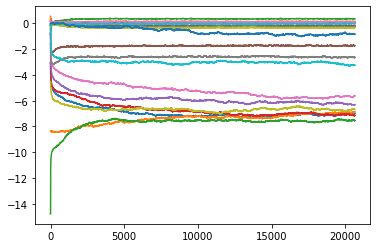

In [3]:
plt.plot(all_thetas)